In [29]:
# import related PySpark libraries

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.functions import col
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler, CountVectorizer, Normalizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics

# import other Python libraries: pandas, matplotlib etc.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import copy
import time
import datetime

%matplotlib inline

In [2]:

import ibmos2spark, os
# @hidden_cell

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_118c0d9e597342f2a9eb90f179b3d34c = 'https://s3-api.us-geo.objectstorage.softlayer.net'
else:
    endpoint_118c0d9e597342f2a9eb90f179b3d34c = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'

credentials = {
    'endpoint': endpoint_118c0d9e597342f2a9eb90f179b3d34c,
    'service_id': 'iam-ServiceId-d9f8bfa3-0350-4e1e-8e94-a38c815b1829',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'fc5U059kpjIEmrasOPVhgfSNbjb9RS9OtFln_NJ7pcgq'
}

configuration_name = 'os_118c0d9e597342f2a9eb90f179b3d34c_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Load and Explore the Dataset

In [3]:
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json
user_log = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-67xjraujyjgfk5'))
user_log.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [4]:
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

# user_log = spark.read.json(cos.url('mini_sparkify_event_data.json', 'sparkify-donotdelete-pr-67xjraujyjgfk5'))
# user_log.take(5)

In [5]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [68]:
user_log.toPandas().shape

(543705, 18)

In [6]:
blank_pages = user_log.filter(user_log.userId == '') \
    .select(col('page') \
    .alias('blank_pages')) \
    .dropDuplicates()

# get a list of possible pages that could be visited
all_pages = user_log.select('page').dropDuplicates()

# find values in all_pages that are not in blank_pages
# these are the pages that the blank user did not go to
for row in set(all_pages.collect()) - set(blank_pages.collect()):
    print(row.page)a

Thumbs Up
Logout
Cancellation Confirmation
Submit Downgrade
Thumbs Down
Upgrade
Cancel
Downgrade
Add to Playlist
Submit Upgrade
Add Friend
Roll Advert
NextSong
Settings
Save Settings


### Drop all Null Ids and Empty Ids

In [7]:
# After loading and preliminary observation of data above, data cleaning operation is started with these items:
# 1. Drop NaN and '' values (empty strings)

#Check missing values and '' data for each column.
print('Count of Missing Values for each Column')
for col in user_log.columns:
    missing_count = user_log.filter((user_log[col] == "") | user_log[col].isNull() | isnan(user_log[col])).count()
    print('{}: '.format(col), missing_count)

Count of Missing Values for each Column
artist:  110828
auth:  0
firstName:  15700
gender:  15700
itemInSession:  0
lastName:  15700
length:  110828
level:  0
location:  15700
method:  0
page:  0
registration:  15700
sessionId:  0
song:  110828
status:  0
ts:  0
userAgent:  15700
userId:  15700


In [8]:
# There are 15700 missing values for userId and other related columns (firstname, lastname etc.) These records should be dropped.
# There are also 110828 missing values for artist, length and song. However, they are ok as all Sparkify transaction is not related with play song in data.

# Clean data: Drop NaN and '' values (empty strings) : 15700 of 543705 = %3 of data is dropped.
user_log_valid = user_log.filter((user_log['userId'] != "") & user_log['userId'].isNotNull() & ~isnan(user_log['userId']))
user_log_valid = user_log_valid.filter((user_log_valid['sessionId'].isNotNull()) & (~isnan(user_log_valid['sessionId'])))

In [9]:
#Checking the missing values and NaN
print('Count of Missing Values after cleaning')
for col in user_log_valid.columns:
    missing_count = user_log_valid.filter((user_log_valid[col] == "") | user_log_valid[col].isNull() | isnan(user_log_valid[col])).count()
    print('{}: '.format(col), missing_count)

Count of Missing Values after cleaning
artist:  95128
auth:  0
firstName:  0
gender:  0
itemInSession:  0
lastName:  0
length:  95128
level:  0
location:  0
method:  0
page:  0
registration:  0
sessionId:  0
song:  95128
status:  0
ts:  0
userAgent:  0
userId:  0


# Exploratory Data Analysis

## Explore Data

In [10]:
# Explore clean data (df_clean) using sparksql
# There are 250 male and 198 female users in data frame. It is approximately balanced data according to gender.
user_log_valid.createOrReplaceTempView("user_log_valid")
spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS user_counts
        FROM user_log_valid
        GROUP BY gender
        ORDER BY user_counts DESC
''').show()

+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|        250|
|     F|        198|
+------+-----------+



In [11]:
# Majority of page event data is composed of "NextSong"
# Cancel Confirmation page event is also 99 and this event will be used to define churn.
spark.sql('''
        SELECT page,COUNT(userId) AS user_counts
        FROM user_log_valid
        GROUP BY page
        ORDER BY user_counts DESC
''').show()

+--------------------+-----------+
|                page|user_counts|
+--------------------+-----------+
|            NextSong|     432877|
|           Thumbs Up|      23826|
|                Home|      19089|
|     Add to Playlist|      12349|
|          Add Friend|       8087|
|         Roll Advert|       7773|
|              Logout|       5990|
|         Thumbs Down|       4911|
|           Downgrade|       3811|
|            Settings|       2964|
|                Help|       2644|
|               About|       1026|
|             Upgrade|        968|
|       Save Settings|        585|
|               Error|        503|
|      Submit Upgrade|        287|
|    Submit Downgrade|        117|
|              Cancel|         99|
|Cancellation Conf...|         99|
+--------------------+-----------+



In [12]:
# There are 370 free and 321 paid account in this dataset. There are 225 userIds in dataframe, so it shows that 135 users have changed their account level.
spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS user_counts
        FROM  user_log_valid
        GROUP BY level
        ORDER BY user_counts DESC
''').show()

+-----+-----------+
|level|user_counts|
+-----+-----------+
| free|        370|
| paid|        321|
+-----+-----------+



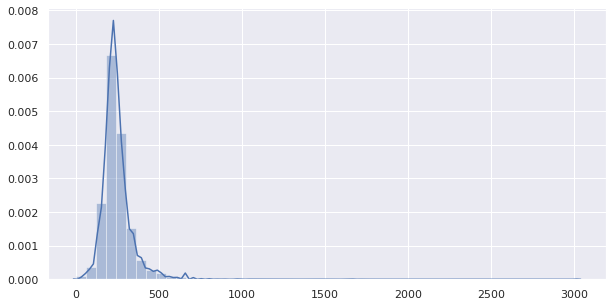

In [13]:
# Length of time for current row of specific log and show distribution of length of event logs
# Majority of lenght is between 0 and 500 minutes. 
length_data = spark.sql('''
        SELECT length
        FROM user_log_valid
''')
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(length_data.toPandas().dropna());

In [14]:
# Define churn label with Cancellation Confirmation page event
churn_page_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
user_log_valid = user_log_valid.withColumn('Churn_Event', churn_page_event('page'))
windowval = Window.partitionBy('userId')
user_log_valid = user_log_valid.withColumn('Churn_Flag', max('Churn_Event').over(windowval))

In [15]:
# There are 99 userIds churned and 349 UserIds who did not churn.
user_log_valid.createOrReplaceTempView("user_log_valid")
spark.sql('''
        SELECT Churn_Flag,COUNT(DISTINCT userId) AS user_counts
        FROM  user_log_valid
        GROUP BY Churn_Flag
        ORDER BY user_counts DESC
''').show()

+----------+-----------+
|Churn_Flag|user_counts|
+----------+-----------+
|         0|        349|
|         1|         99|
+----------+-----------+



In [16]:
# Define Downgrade label with Submit Downgrade page event
downgrade_page_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
user_log_valid = user_log_valid.withColumn("Downgrade_Event", downgrade_page_event("page"))
windowval = Window.partitionBy('userId')
user_log_valid = user_log_valid.withColumn('Downgrade_Flag', max('Downgrade_Event').over(windowval))

In [17]:
# There are 97 userIds downgraded and 351 UserIds who did not downgrade.
user_log_valid.createOrReplaceTempView("user_log_valid")
spark.sql('''
        SELECT Downgrade_Flag,COUNT(DISTINCT userId) AS user_counts
        FROM  user_log_valid
        GROUP BY Downgrade_Flag
        ORDER BY user_counts DESC
''').show()

+--------------+-----------+
|Downgrade_Flag|user_counts|
+--------------+-----------+
|             0|        351|
|             1|         97|
+--------------+-----------+



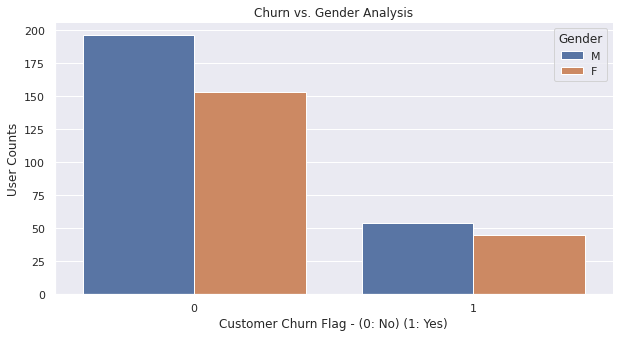

In [18]:
# Explore churn pattern according to gender: Male customers are more likely to churn than female customers.
user_log_valid.createOrReplaceTempView("user_log_valid")
churn_gender_analysis_pd = spark.sql('''
        SELECT gender, Churn_Flag, COUNT( DISTINCT userId) AS user_counts
        FROM  user_log_valid
        GROUP BY  gender, Churn_Flag
        ORDER BY user_counts DESC
''').toPandas()
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.barplot(x='Churn_Flag', y='user_counts', hue='gender', data=churn_gender_analysis_pd)
plt.xlabel('Customer Churn Flag - (0: No) (1: Yes)')
plt.ylabel('User Counts')
plt.legend(title='Gender', loc='best')
plt.title('Churn vs. Gender Analysis')
sns.despine(ax=ax);

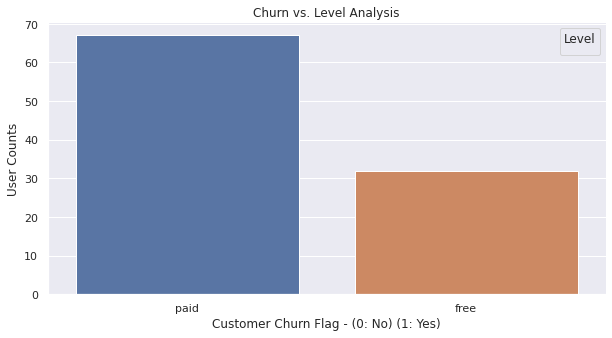

In [19]:
# Explore churn pattern according to level (paid and free): Customers having paid account are more likely to churn than customers having free account.
user_log_valid.createOrReplaceTempView("user_log_valid")
churn_level_analysis_pd = spark.sql('''
        SELECT level, COUNT(DISTINCT userId) AS user_counts
        FROM  user_log_valid
        WHERE page == "Cancellation Confirmation"
        GROUP BY level
        ORDER BY user_counts DESC
''').toPandas()
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.barplot(x='level', y='user_counts', data=churn_level_analysis_pd)
plt.xlabel('Customer Churn Flag - (0: No) (1: Yes)')
plt.ylabel('User Counts')
plt.legend(title='Level', loc='best')
plt.title('Churn vs. Level Analysis')
sns.despine(ax=ax);

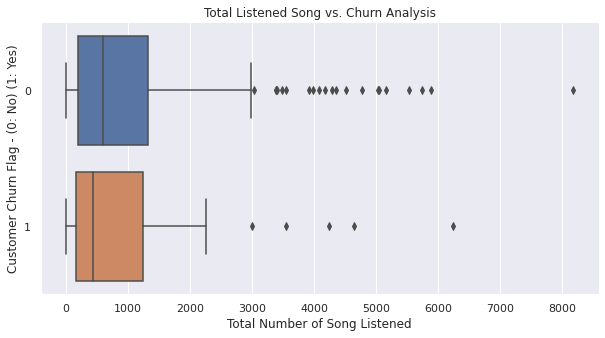

In [20]:
# Total number of song listened vs. Churn Analysis
# It shows that users churned listen less song.
user_log_valid.createOrReplaceTempView("user_log_valid")
churn_listenedsong_analysis_pd = spark.sql('''
        SELECT Churn_Flag, userID, sum(page_counts) AS sum_page_counts
        FROM
        (SELECT Churn_Flag, userId, count(page) AS page_counts
        FROM  user_log_valid
        WHERE page == "NextSong"
        GROUP BY Churn_Flag, userId)
        GROUP BY Churn_Flag, userID
''').toPandas()

ax = sns.boxplot(data=churn_listenedsong_analysis_pd, y='Churn_Flag', x='sum_page_counts', orient='h')
plt.xlabel('Total Number of Song Listened')
plt.ylabel('Customer Churn Flag - (0: No) (1: Yes)')
plt.title('Total Listened Song vs. Churn Analysis')
sns.despine(ax=ax);

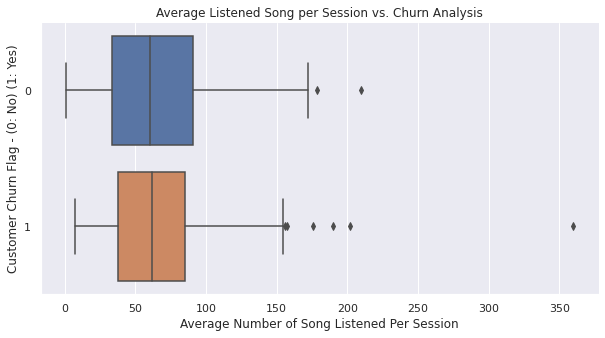

In [21]:
# It shows that users churned listen less song per session.
user_log_valid.createOrReplaceTempView("user_log_valid")
churn_ses_listenedsong_analysis_pd = spark.sql('''
        SELECT Churn_Flag, userID, avg(page_counts) AS avg_page_counts
        FROM
        (SELECT Churn_Flag, userId, sessionid, count(page) AS page_counts
        FROM  user_log_valid
        WHERE page == "NextSong"
        GROUP BY Churn_Flag, userId, sessionid)
        GROUP BY Churn_Flag, userID
''').toPandas()

ax = sns.boxplot(data=churn_ses_listenedsong_analysis_pd, y='Churn_Flag', x='avg_page_counts', orient='h')
plt.xlabel('Average Number of Song Listened Per Session')
plt.ylabel('Customer Churn Flag - (0: No) (1: Yes)')
plt.title('Average Listened Song per Session vs. Churn Analysis')
sns.despine(ax=ax);

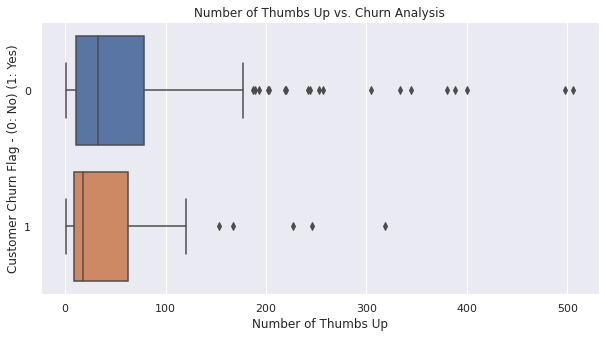

In [22]:
# Number of thumbs up vs. Churn Analysis: It shows that users churned make less thumbs up. 
user_log_valid.createOrReplaceTempView("user_log_valid")
thumbs_up_analysis_pd = spark.sql('''
        SELECT Churn_Flag, userId, count(page) AS page_counts
        FROM  user_log_valid
        WHERE page == "Thumbs Up"
        GROUP BY Churn_Flag, userId
''').toPandas()

ax = sns.boxplot(data=thumbs_up_analysis_pd, y='Churn_Flag', x='page_counts', orient='h')
plt.xlabel('Number of Thumbs Up')
plt.ylabel('Customer Churn Flag - (0: No) (1: Yes)')
plt.title('Number of Thumbs Up vs. Churn Analysis')
sns.despine(ax=ax);

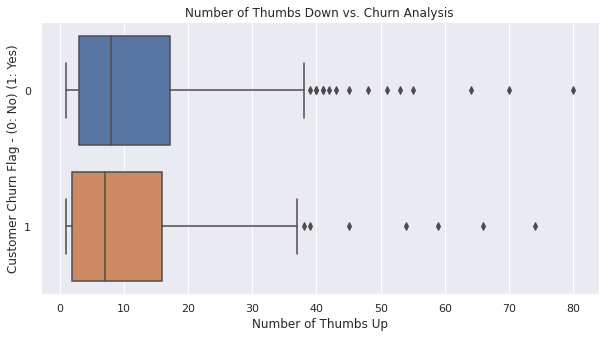

In [23]:
# Number of thumbs down vs. Churn Analysis: It shows that users churned make less thumbs up. 
user_log_valid.createOrReplaceTempView("user_log_valid")
thumbs_up_analysis_pd = spark.sql('''
        SELECT Churn_Flag, userId, count(page) AS page_counts
        FROM  user_log_valid
        WHERE page == "Thumbs Down"
        GROUP BY Churn_Flag, userId
''').toPandas()

ax = sns.boxplot(data=thumbs_up_analysis_pd, y='Churn_Flag', x='page_counts', orient='h')
plt.xlabel('Number of Thumbs Up')
plt.ylabel('Customer Churn Flag - (0: No) (1: Yes)')
plt.title('Number of Thumbs Down vs. Churn Analysis')
sns.despine(ax=ax);

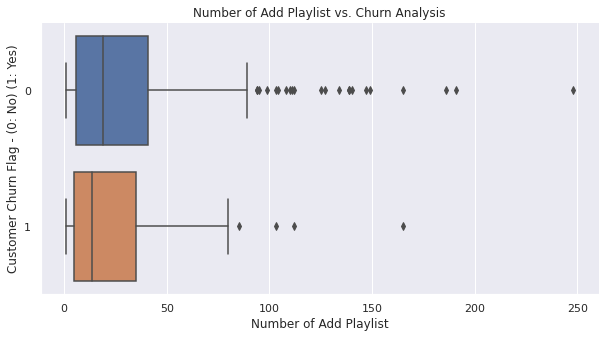

In [24]:
# Number of Add Playlist vs. Churn Analysis: It shows that users churned make less "add playlist" 
user_log_valid.createOrReplaceTempView("user_log_valid")
playlist_analysis_pd = spark.sql('''
        SELECT Churn_Flag, userId, count(page) AS page_counts
        FROM  user_log_valid
        WHERE page == "Add to Playlist"
        GROUP BY Churn_Flag, userId
''').toPandas()

ax = sns.boxplot(data=playlist_analysis_pd, y='Churn_Flag', x='page_counts', orient='h')
plt.xlabel('Number of Add Playlist')
plt.ylabel('Customer Churn Flag - (0: No) (1: Yes)')
plt.title('Number of Add Playlist vs. Churn Analysis')
sns.despine(ax=ax);

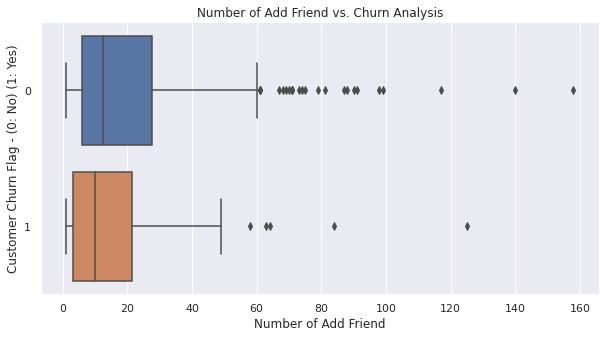

In [25]:
# Number of Add Friend vs. Churn Analysis: It shows that users churned make less "add friend" 
user_log_valid.createOrReplaceTempView("user_log_valid")
addfriend_analysis_pd = spark.sql('''
        SELECT Churn_Flag, userId, count(page) AS page_counts
        FROM  user_log_valid
        WHERE page == "Add Friend"
        GROUP BY Churn_Flag, userId
''').toPandas()

ax = sns.boxplot(data=addfriend_analysis_pd, y='Churn_Flag', x='page_counts', orient='h')
plt.xlabel('Number of Add Friend')
plt.ylabel('Customer Churn Flag - (0: No) (1: Yes)')
plt.title('Number of Add Friend vs. Churn Analysis')
sns.despine(ax=ax);

In [26]:
# Calculate register duration from registration date to last page event times. 
last_page_event_df =  user_log_valid.groupBy('userId', 'Churn_Flag').agg(max('ts').alias('last_page_event'))
registration_df = user_log_valid.groupBy('userId').agg(max('registration').alias('registration'))
# Join two spark dataframes
df_register_duration = last_page_event_df.join(registration_df, on=['userID'], how='inner')
# Convert last page event and registration dates to human readable formats
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_register_duration = df_register_duration.withColumn('page_event_time_human', convert_ts('last_page_event'))
df_register_duration = df_register_duration.withColumn('registration_human', convert_ts('registration'))
#  Obtain day difference of last page event and registration dates and assign into Registration Duration
df_register_duration = df_register_duration.withColumn("Register_Duration", datediff('page_event_time_human', 'registration_human'))

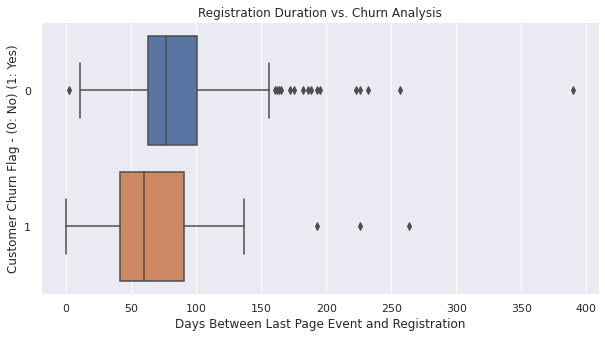

In [27]:
# Registration Duration vs. Churn Analysis - Graph using df_register_duration dataframe.
# It shows that customers churned use Sparkify service for a shorter period.
df_register_duration_pd = df_register_duration.toPandas()
ax = sns.boxplot(data=df_register_duration_pd, y='Churn_Flag', x='Register_Duration', orient='h')
plt.xlabel('Days Between Last Page Event and Registration')
plt.ylabel('Customer Churn Flag - (0: No) (1: Yes)')
plt.title('Registration Duration vs. Churn Analysis')
sns.despine(ax=ax);

# Feature Engineering

#### After performing the EDA on the data above, I have shortlisted the following features that I will be using in my Model
1. Total time since registration
2. Average songs played per session
3. Number of thumbs up
4. Number of thumbs down
5. Total songs listened
6. Total songs added to playlist
7. Gender
8. Total number of friends
9. Level - paid or free
10. Total length of listening
11. Downgraded


 Output : Churn Status / Label

In [30]:
# Total time since registration
total_lifetime = user_log_valid.select('userId', 'registration', 'ts').withColumn('total_lifetime', (user_log_valid.ts - user_log_valid.registration))\
    .groupBy('userId').agg({'total_lifetime' : 'max'})\
    .withColumnRenamed('max(total_lifetime)', 'total_lifetime')\
    .select('userId', (col('total_lifetime')/1000/3600/24).alias('total_lifetime'))
total_lifetime.show(5)

+------+------------------+
|userId|    total_lifetime|
+------+------------------+
|100010|14.328449074074074|
|200002| 53.32314814814814|
|   296| 26.63826388888889|
|   125|105.42211805555554|
|    51| 18.84582175925926|
+------+------------------+
only showing top 5 rows



In [31]:
# Average songs played per session
avg_song_played = user_log_valid.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'avg_songs_played')
avg_song_played.show(5)

+------+------------------+
|userId|  avg_songs_played|
+------+------------------+
|100010|              48.0|
|200002|              62.0|
|   296|              22.4|
|   125|20.666666666666668|
|     7|              30.8|
+------+------------------+
only showing top 5 rows



In [32]:
# Number of thumbs up
num_thumbs_up = user_log_valid.select('userId', 'page').where(user_log_valid.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'num_thumbs_up')
num_thumbs_up.show(5)

+------+-------------+
|userId|num_thumbs_up|
+------+-------------+
|100010|            4|
|200002|           15|
|   296|            8|
|   125|            3|
|    51|           16|
+------+-------------+
only showing top 5 rows



In [33]:
# Number of thumbs down
num_thumbs_down = user_log_valid.select('userId', 'page').where(user_log_valid.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'num_thumbs_down')
num_thumbs_down.show(5)

+------+---------------+
|userId|num_thumbs_down|
+------+---------------+
|100010|              3|
|200002|              5|
|   125|              1|
|   124|             15|
|    51|              1|
+------+---------------+
only showing top 5 rows



In [34]:
# Total songs listened
total_songs_listened = user_log_valid.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'total_songs_listened')
total_songs_listened.show(5)

+------+--------------------+
|userId|total_songs_listened|
+------+--------------------+
|100010|                 137|
|200002|                 395|
|   296|                 152|
|   125|                  84|
|   124|                2156|
+------+--------------------+
only showing top 5 rows



In [35]:
# Total songs added to playlist
add_to_playlist = user_log_valid.select('userID','page').where(user_log_valid.page == 'Add to Playlist').groupBy('userID').count().withColumnRenamed('count', 'add_to_playlist')
add_to_playlist.show(5)

+------+---------------+
|userID|add_to_playlist|
+------+---------------+
|   296|              3|
|100010|              1|
|200002|              6|
|   125|              2|
|   124|             45|
+------+---------------+
only showing top 5 rows



In [36]:
# Gender
gender = user_log_valid.select("userId", "gender").dropDuplicates()
gender = gender.replace(['M', 'F'], ['1', '0'], 'gender')  
gender = gender.withColumn("gender",gender["gender"].cast(IntegerType()))
gender.show(5)

+------+------+
|userId|gender|
+------+------+
|   234|     1|
|   188|     0|
|    44|     0|
|   273|     1|
|    46|     0|
+------+------+
only showing top 5 rows



In [37]:
# Total number of friends
total_friends = user_log_valid.select('userId', 'page').where(user_log_valid.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'total_friends')
total_friends.show(5)

+------+-------------+
|userId|total_friends|
+------+-------------+
|100010|            3|
|200002|            2|
|   296|            2|
|   125|            3|
|   124|           26|
+------+-------------+
only showing top 5 rows



In [38]:
# Level
level = user_log_valid.select("userId", "level").dropDuplicates()
level = level.replace(['paid', 'free'], ['1', '0'], 'level')  
level = level.withColumn("level",level["level"].cast(IntegerType()))
level.show(5)

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|100029|    0|
|    94|    1|
|200050|    1|
|    18|    0|
+------+-----+
only showing top 5 rows



In [39]:
# Total length of listening
total_length_listening = user_log_valid.select('userID','length').groupBy('userID').sum().withColumnRenamed('sum(length)', 'length')
total_length_listening.show(5)

+------+------------------+
|userID|            length|
+------+------------------+
|100010|25870.950739999997|
|200002| 78695.82683999998|
|   296|28314.150059999996|
|   125|15813.771070000003|
|   124|      456664.04058|
+------+------------------+
only showing top 5 rows



In [40]:
# Downgraded
downgrade = user_log_valid.select('userId', 'Downgrade_Flag').dropDuplicates().select('userId', col("Downgrade_Flag").cast('int'))
downgrade.show(5)

+------+--------------+
|userId|Downgrade_Flag|
+------+--------------+
|100010|             0|
|200002|             0|
|   296|             0|
|   125|             0|
|   124|             0|
+------+--------------+
only showing top 5 rows



In [41]:
churn = user_log_valid.select('userId', 'Churn_Flag').dropDuplicates()
churn.show(5)

+------+----------+
|userId|Churn_Flag|
+------+----------+
|100010|         1|
|200002|         1|
|   296|         1|
|   125|         0|
|   124|         1|
+------+----------+
only showing top 5 rows



In [42]:
def features_merge(df1, df2):
    """  
    INPUT: 
    df1 - dataframe to be merged
    df2 - dataframe to be merged and remove its key
    
    OUTPUT: 
    df - merged dataframe
    
    Description: 
    This function is used to merge the feature using left join. 
    """
    
    df2 = df2.withColumnRenamed("userId", "userId_dup")
    df = df1.join(df2, df1.userId == df2.userId_dup, "left").drop("userId_dup")
    return df

In [43]:
features_list = [total_songs_listened, num_thumbs_up, num_thumbs_down, total_lifetime, avg_song_played, add_to_playlist, total_friends, downgrade, gender, level, total_length_listening]

In [44]:
# Churn Status / Label
target = user_log_valid.select('userId', col('Churn_Flag').alias('target')).dropDuplicates()
target.show(5)

+------+------+
|userId|target|
+------+------+
|100010|     1|
|200002|     1|
|   296|     1|
|   125|     0|
|   124|     1|
+------+------+
only showing top 5 rows



In [45]:
df_final = target

for feature in features_list:
    feature.show(5)
    df_final = features_merge(df_final, feature)

+------+--------------------+
|userId|total_songs_listened|
+------+--------------------+
|   296|                 152|
|100010|                 137|
|200002|                 395|
|   125|                  84|
|    51|                 328|
+------+--------------------+
only showing top 5 rows

+------+-------------+
|userId|num_thumbs_up|
+------+-------------+
|   296|            8|
|100010|            4|
|200002|           15|
|   125|            3|
|    51|           16|
+------+-------------+
only showing top 5 rows

+------+---------------+
|userId|num_thumbs_down|
+------+---------------+
|100010|              3|
|200002|              5|
|   125|              1|
|   124|             15|
|    51|              1|
+------+---------------+
only showing top 5 rows

+------+------------------+
|userId|    total_lifetime|
+------+------------------+
|100010|14.328449074074074|
|200002| 53.32314814814814|
|   296| 26.63826388888889|
|   125|105.42211805555554|
|    51| 18.84582175925926|

In [46]:
df_final = df_final.na.fill(0)
df_final = df_final.orderBy('userId', ascending=True)

In [47]:
df_final.show(5)

+------+------+--------------------+-------------+---------------+------------------+-----------------+---------------+-------------+--------------+------+-----+------------------+
|userId|target|total_songs_listened|num_thumbs_up|num_thumbs_down|    total_lifetime| avg_songs_played|add_to_playlist|total_friends|Downgrade_Flag|gender|level|            length|
+------+------+--------------------+-------------+---------------+------------------+-----------------+---------------+-------------+--------------+------+-----+------------------+
|    10|     1|                 423|           17|              1|10.368854166666667|            360.0|             14|            3|             0|     1|    1|       90524.44076|
|   100|     0|                3999|          143|             37| 65.09505787037037|86.71794871794872|             94|           71|             0|     1|    0| 829748.3311199999|
|   100|     0|                3999|          143|             37| 65.09505787037037|86.7179487

In [49]:
df_final.write.save('medium_df_final_model_data.json',format='json',header=True)

# Modelling

In [50]:
# Read model data from json file.
model_data = spark.read.json('medium_df_final_model_data.json')
# change column name Churn_Label to label
model_data = model_data.withColumnRenamed("target","label")
# Check columns and shape
model_data.printSchema()
model_data.toPandas().shape

root
 |-- Downgrade_Flag: long (nullable = true)
 |-- add_to_playlist: long (nullable = true)
 |-- avg_songs_played: double (nullable = true)
 |-- gender: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: long (nullable = true)
 |-- num_thumbs_down: long (nullable = true)
 |-- num_thumbs_up: long (nullable = true)
 |-- label: long (nullable = true)
 |-- total_friends: long (nullable = true)
 |-- total_lifetime: double (nullable = true)
 |-- total_songs_listened: long (nullable = true)
 |-- userId: string (nullable = true)



(691, 13)

In [51]:
# Three ML algorithms will be used to build model and f1 score will be used to optimize.  These are
# 1. Logistic Regression, 2. Random Forest Classifier and 3. Gradient Boosting Trees
# First of vectorize numerical variables in model data, transform them for feature pipeline.
columns = []   
for field in model_data.schema.fields :
            columns.append(field.name)

columns.remove('label')
columns.remove('userId')
assembler = VectorAssembler(inputCols=columns, outputCol="num_features")
model_data = assembler.transform(model_data)

# using standard scaler
scaler = StandardScaler(inputCol="num_features", outputCol="features", withStd=True)
scalerModel = scaler.fit(model_data)
model_data = scalerModel.transform(model_data)

In [52]:
#Split the full dataset into train, test, and validation sets.
train, rest = model_data.randomSplit([0.6, 0.4], seed=42)
validation, test = rest.randomSplit([0.5, 0.5], seed=42)

In [53]:
# import time to calculate model training duration (seconds)
from time import time

# 1. Logistic Regression 

# initialize classifier, set evaluater and build paramGrid
lr = LogisticRegression(maxIter=10)
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder().build()
crossval_lr = CrossValidator(estimator=lr, evaluator=f1_evaluator, estimatorParamMaps=paramGrid,numFolds=3)

# Calculate time metric of model. 
start_time = time()
cvModel_lr = crossval_lr.fit(train)
end_time = time()
cvModel_lr.avgMetrics
seconds = end_time- start_time

results_lr = cvModel_lr.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

print('Logistic Regression Metrics:')
print('Accuracy of model is : {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print('F1 score of model is :{}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))
print('The training process of model took {} seconds'.format(seconds))

Logistic Regression Metrics:
Accuracy of model is : 0.7443609022556391
F1 score of model is :0.6724855617304131
The training process of model took 13.907336235046387 seconds


In [54]:
# 2. Random Forest Classifier 

# initialize classifier, set evaluater and build paramGrid
rf = RandomForestClassifier()
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder().build()
crossval_rf = CrossValidator(estimator=rf,estimatorParamMaps=paramGrid,evaluator=f1_evaluator,numFolds=3)

# Calculate time metric of model. 
start_time = time()
cvModel_rf = crossval_rf.fit(train)
end_time = time()
cvModel_rf.avgMetrics
seconds = end_time- start_time

results_rf = cvModel_rf.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

print('Random Forest Metrics:')
print('Accuracy of model is : {}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "accuracy"})))
print('F1 score of model is :{}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "f1"})))
print('The training process of model took {} seconds'.format(seconds))

Random Forest Metrics:
Accuracy of model is : 0.7969924812030075
F1 score of model is :0.7585255822483037
The training process of model took 12.764495134353638 seconds


In [55]:
# 3. Gradient Boosting Trees

# initialize classifier, set evaluater and build paramGrid
gbt = GBTClassifier(maxIter=10,seed=42)
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder().build()
crossval_gbt = CrossValidator(estimator=gbt,estimatorParamMaps=paramGrid,evaluator=f1_evaluator,numFolds=3)

# Calculate time metric of model. 
start_time = time()
cvModel_gbt = crossval_gbt.fit(train)
end_time = time()
cvModel_gbt.avgMetrics
seconds = end_time- start_time

results_gbt = cvModel_gbt.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

print('Gradient Boosted Trees Metrics:')
print('Accuracy of model is : {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"})))
print('F1 score of model is :{}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})))
print('The training process of model took {} seconds'.format(seconds))

Gradient Boosted Trees Metrics:
Accuracy of model is : 0.8270676691729323
F1 score of model is :0.799474962304081
The training process of model took 31.332529306411743 seconds


## Summary of Three Models:
Logistics Regression Model takes 13.9 training seconds with 0.744 accuracy and 0.672 f1-score
Random Forrest Model takes 12.76 training seconds with 0.796 accuracy and 0.758 f1-score
Gradient Boosted Trees Model takes 31.33 training seconds with 0.827 accuracy and 0.799 f1-score

### Why Gradient Boosted Model is best for our scenario:

First of all we used f1-score to select our final model because our problem is classification one and f1-score can help us to find the balance between accuracy and recall. Higher the f1-score the more perfect our model will be as false negative and false positive will be less.

Here Gradient Boosted Trees has best f1-score that's why I choose it for the next steps.

In [62]:
# Optimizing Hyperparameters in Random Forest Classification
clf = GBTClassifier()
maxIter=[5,10,20]
maxDepth=[10,20]    
paramGrid = ParamGridBuilder().addGrid(clf.maxIter, maxIter).addGrid(clf.maxDepth, maxDepth).build()       
crossval = CrossValidator(estimator = Pipeline(stages=[clf]),
                         estimatorParamMaps = paramGrid,
                         evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds = 3)

cvModel_gbt = crossval.fit(train)
predictions = cvModel_gbt.transform(test)

evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = evaluator.evaluate(predictions.select(col('label'), col('prediction')))
print('The F1 score is {:.2%}'.format(f1_score)) 
   
bestPipeline = cvModel_gbt.bestModel

print('Best parameters : max depth:{}, max Iter:{}'.format(bestPipeline.stages[0].getOrDefault('maxDepth'), bestPipeline.stages[0].getOrDefault('maxIter')))

The F1 score is 81.85%
Best parameters : max depth:10, max Iter:5


In [69]:
# Best Model: Random Forrest Model with max depth:10, num Trees:75 parameters
gbt_best = GBTClassifier(maxIter=5, maxDepth=10)
gbt_best_model = gbt_best.fit(train)
result = gbt_best_model.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Gradient Boosted Trees Model - Test Metrics with best parameters:')
print('Accuracy of model is :  {}'.format(evaluator.evaluate(result, {evaluator.metricName: "accuracy"})))
print('F1 score of model is : {}'.format(evaluator.evaluate(result, {evaluator.metricName: "f1"})))

Gradient Boosted Trees Model - Test Metrics with best parameters:
Accuracy of model is :  0.8287671232876712
F1 score of model is : 0.8184619228046801


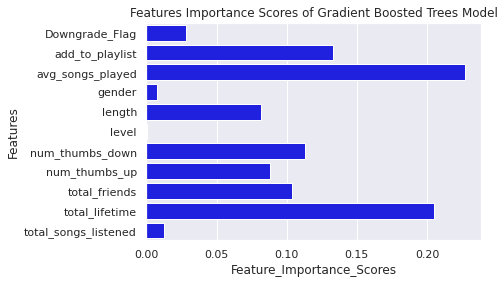

In [70]:
# Features importance of Random Forrest Model 
Feature_Importance_Scores = gbt_best_model.featureImportances.values.tolist()
Feature_Importance_df = pd.DataFrame({'Feature_Importance_Scores': Feature_Importance_Scores, 'Features': columns})
plt.title('Features Importance Scores of Gradient Boosted Trees Model')
sns.barplot(x='Feature_Importance_Scores', y='Features', data=Feature_Importance_df, color="blue")

# Final Steps

In [71]:
##In Sparkify Project, I try to generate model predicting customer churn. First of all;
# 1. Load mini json file, clean data and make ready for explanatory data analysis.
# 2. Perform explanatory data analysis, define churn and try to determine features which will be used in model.
# 3. Define 10 features which will be used in model while predicting churn. 
# 4. Select three models which are logistic regression, random forrest and gradient boosting trees to compare model. 
# 5. Select random forrest  model as the final model implemented for predicting final result and also fine-tuning its parameters. I can obtain  approximately 92% accuracy and 0.913 f1 score with this model. 
# 6. Finally, I observe that register_duration (days), number of thumbs down and average listened songs per session are top 3 important features while predicting churn.